In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [2]:
width = 516
height = 300
num_classes = 3
classes = ["posev", "thumb", "metal"]

In [3]:
TRAINING_CSV_FILE = 'Data/training_data.csv'
TRAINING_IMAGE_DIR = 'Images/Training'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)

train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

train_images = []
train_targets = []
train_labels = []

for index, row in training_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    train_image_fullpath = os.path.join(train_image_path, filename)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))

In [4]:
VALIDATION_CSV_FILE = 'Data/validation_data.csv'
VALIDATION_IMAGE_DIR = 'Images/Validation'

validation_image_records = pd.read_csv(VALIDATION_CSV_FILE)

validation_image_path = os.path.join(os.getcwd(), VALIDATION_IMAGE_DIR)

validation_images = []
validation_targets = []
validation_labels = []

for index, row in validation_image_records.iterrows():
    
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    
    validation_image_fullpath = os.path.join(validation_image_path, filename)
    validation_img = keras.preprocessing.image.load_img(validation_image_fullpath, target_size=(height, width))
    validation_img_arr = keras.preprocessing.image.img_to_array(validation_img)
    
    
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    validation_images.append(train_img_arr)
    validation_targets.append((xmin, ymin, xmax, ymax))
    validation_labels.append(classes.index(class_name))

In [5]:
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

In [6]:
#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(4, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Dropout(0.2, name='bl_8')(base_layers)
base_layers = layers.Flatten(name='bl_9')(base_layers)

#create the classifier branch
classifier_branch = layers.Dense(64, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch) 

#create the localiser branch
locator_branch = layers.Dense(64, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(32, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(18, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [7]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 516, 3)]        0         []                            
                                                                                                  
 bl_1 (Rescaling)            (None, 300, 516, 3)          0         ['input_1[0][0]']             
                                                                                                  
 bl_2 (Conv2D)               (None, 300, 516, 4)          112       ['bl_1[0][0]']                
                                                                                                  
 bl_3 (MaxPooling2D)         (None, 150, 258, 4)          0         ['bl_2[0][0]']                
                                                                                              

In [9]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [10]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [11]:
training_epochs = 10

train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(validation_images)
validation_targets = np.array(validation_targets)
validation_labels = np.array(validation_labels)

In [12]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [13]:
print(type(trainTargets))

<class 'dict'>


In [14]:
history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=4,
             epochs=training_epochs,
             shuffle=True,
             verbose=1)

Epoch 1/10


39/39 [==============================] - 11s 210ms/step - loss: 4.5844 - cl_head_loss: 4.5050 - bb_head_loss: 0.0794 - cl_head_accuracy: 0.3922 - bb_head_accuracy: 0.4510 - val_loss: 1.1957 - val_cl_head_loss: 1.1537 - val_bb_head_loss: 0.0420 - val_cl_head_accuracy: 0.2143 - val_bb_head_accuracy: 0.3571
Epoch 2/10
39/39 [==============================] - 8s 198ms/step - loss: 1.0513 - cl_head_loss: 1.0272 - bb_head_loss: 0.0241 - cl_head_accuracy: 0.4706 - bb_head_accuracy: 0.7974 - val_loss: 1.8950 - val_cl_head_loss: 1.8001 - val_bb_head_loss: 0.0949 - val_cl_head_accuracy: 0.2143 - val_bb_head_accuracy: 0.3571
Epoch 3/10
39/39 [==============================] - 8s 197ms/step - loss: 0.7883 - cl_head_loss: 0.7718 - bb_head_loss: 0.0164 - cl_head_accuracy: 0.6144 - bb_head_accuracy: 0.8105 - val_loss: 5.5029 - val_cl_head_loss: 5.3984 - val_bb_head_loss: 0.1045 - val_cl_head_accuracy: 0.2143 - val_bb_head_accuracy: 0.3571
Epoch 4/10
39/39 [==============================]

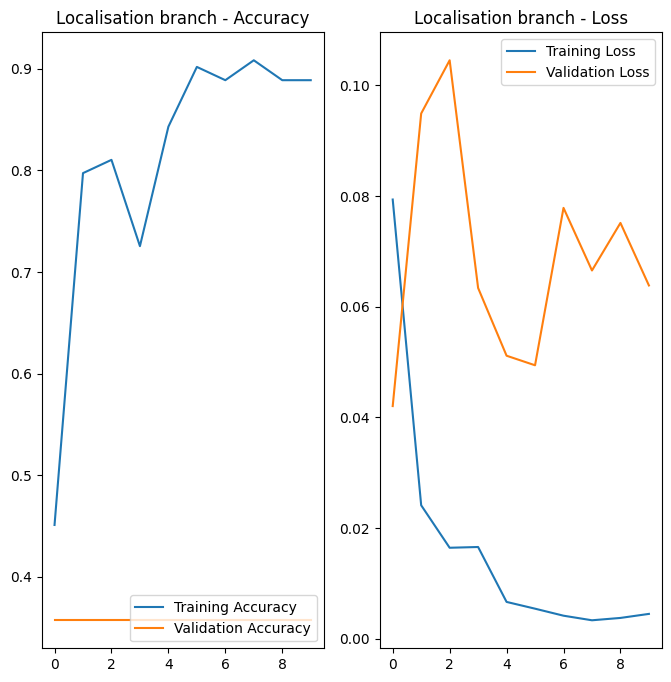

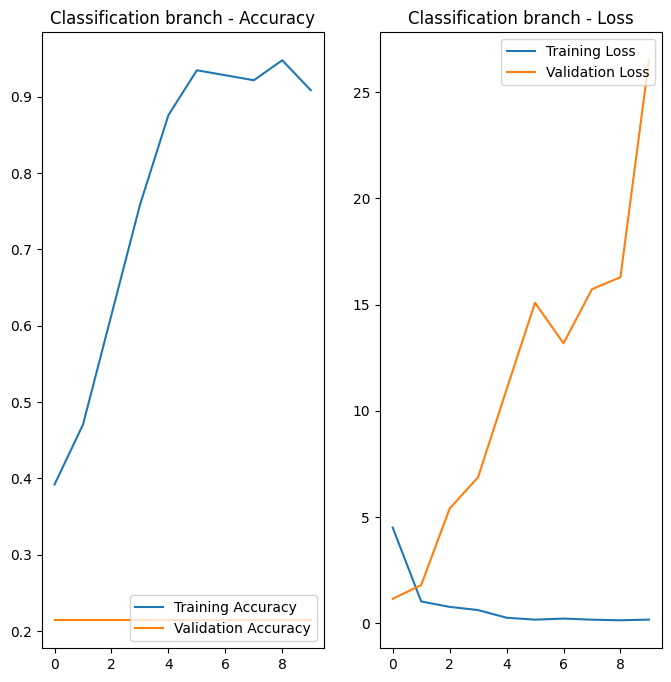

In [15]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']


epochs_range = range(training_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

In [17]:
validation_img = 'Images\Test\WIN_20240112_09_47_37_Pro_jpg.rf.97688d62f7955561b3ce5317b3286387.jpg'

img = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))

img = keras.preprocessing.image.img_to_array(img)
img = tf.expand_dims(img, 0)
predictions = model.predict(img)

1/1 [==============================] - 0s 182ms/step


In [18]:
print(predictions[1][0])

[0.3933513  0.22000115 0.6763443  0.5404094 ]


In [19]:
bbox = predictions[1][0]
bbox = [bbox[0] * width, bbox[1] * height, bbox[2] * width, bbox[3] * height]
print(bbox)

class_prediction_value = predictions[0][0]
score = tf.nn.softmax(class_prediction_value)

print(score)
score = tf.math.argmax(score)
print("Predicted class: {}".format(classes[score]))

[202.96926391124725, 66.00034385919571, 348.99364614486694, 162.12281584739685]
tf.Tensor([0.79648715 0.06565426 0.13785864], shape=(3,), dtype=float32)
Predicted class: posev


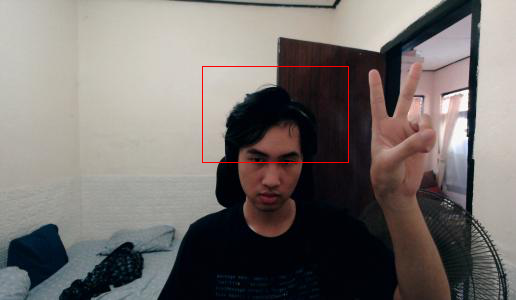

In [20]:
testimg = keras.preprocessing.image.load_img(validation_img, target_size=(height, width))
draw1 = Draw(testimg)
draw1.rectangle(bbox, outline='red')
testimg

In [22]:
model.save('./Saved-Models/model.h5')

C:\Users\WISNADI\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save_weights('./Saved-Models/model_weights.h5')

In [21]:
model.save('./Saved-Models/Locator')

INFO:tensorflow:Assets written to: ./Saved-Models/Locator\assets


INFO:tensorflow:Assets written to: ./Saved-Models/Locator\assets
